**Goals**

Have a model that allows us to make system load balancing decisions based on demand
forecasting based on historical data. Load balancing means the planning of transporting
bicycles from one station to another.

**Outcome**

A model that indicates the optimal movement of bicycles to be made between stations,
and at what times or frequencies, to ensure that you perform the best system planning.

# Importing Modules & Data

In [1]:
import pandas as pd 
import numpy as np
import geopandas as gpd
import fiona
import os
import zipfile
from folium import Map, CircleMarker, Vega, Popup, Marker, PolyLine, Icon, Choropleth, LayerControl
from folium.plugins import MarkerCluster, HeatMap, BeautifyIcon
import shapely
import matplotlib
from ipywidgets import interact
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.tsa 
from datetime import datetime
import missingno as msno
import re

In [2]:
pd.set_option('display.max_rows', 100)

## Class Databases 

In [3]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
class Databases:
    def __init__(self, csv, anva, smm, metro):
        self.csv = csv
        self.anva = anva 
        self.smm = smm
        self.metro = metro

    def extract_csv(self):
        file = pd.read_csv(f'data/bike_loans/{self.csv}', sep=';')
        file['Fecha_Prestamo'] = pd.to_datetime(file['Fecha_Prestamo'])
        file['Fecha_Devolucion'] = pd.to_datetime(file['Fecha_Devolucion'])
        return file
        
    
    def extract_anva(self):
        bus_routes_AMVA = gpd.GeoDataFrame()
        for root, dirs, files in os.walk(f'data/bus_routes/medellin_bus_routes/{self.anva}'):
            for file in files:
                path = os.path.join(root, file)
                df = gpd.read_file(path, driver='KML')
                bus_routes_AMVA = gpd.GeoDataFrame(pd.concat([bus_routes_AMVA, df], ignore_index=True))
        return bus_routes_AMVA
    
    def extract_smm(self):
        smm_bus_routes = gpd.GeoDataFrame()
        for root, dirs, files in os.walk(f'data/bus_routes/medellin_bus_routes/{self.smm}'):
            for file in files:
                path = os.path.join(root, file)
                df = gpd.read_file(path, driver='KML')
                smm_bus_routes = gpd.GeoDataFrame(pd.concat([smm_bus_routes, df], ignore_index=True))
        return smm_bus_routes
    
    def extract_metro(self):
        metro_routes = gpd.GeoDataFrame()
        for root, dirs, files in os.walk(f'data/medellin_metro/{self.metro}'):
            for file in files:
                path = os.path.join(root, file)
                print(path)
                if path.endswith('.kmz'):
                    kmz = zipfile.ZipFile(path, 'r')
                    kml = kmz.open('doc.kml', 'r')
                    df = gpd.read_file(kml, driver='KML')
                    metro_routes = gpd.GeoDataFrame(pd.concat([metro_routes, df], ignore_index=True))
        return metro_routes

In [4]:
databases = Databases('bike_loans.csv','Kml Ruta AMVA','kml Ruta SMM','medellin_metro_stations')

In [5]:
# extracting csv bikes with datetime data
bikes = databases.extract_csv()

In [6]:
bikes.dtypes #checking feature types

Id_Historico_Prestamo               int64
Id_Usuario                          int64
Id_Tag_Bicicleta                   object
Fecha_Prestamo             datetime64[ns]
Fecha_Devolucion           datetime64[ns]
Id_Aparcamiento_Origen              int64
Posicion_Origen                     int64
Id_Aparcamiento_Destino           float64
Posicion_Destino                  float64
Importe                           float64
DescripcionImporte                float64
operario                           object
Num_Bici_Hist                     float64
dtype: object

# Data Cleaning

In order to capture **trends and seasonality** properly, we decided to focus on **pre-pandemic** data. The first case diagnosed of Covid-19 in Colombia was on March 6th, 2020. Therefore, in order to avoid any bias in the data, we decided to focus on the data prior to 2020.

Following some review, we decided to focus entirely on the data from **2019**. There are several reasons for this. First, we believe that using data at the beginning of the project might be unrepresentative of how it is currently operated (just before COVID). Secondly, for dimensionality purposes, the more rows and dates we turn into time series, the great amount of data to process. 

**Homemade Dict**

In [7]:
# Id_Historico_Prestamo - represents ID of the load
# Id_Usuario - id of the users
# Id_Tag_Bicicleta - Id of the bycicle
# Fecha_Prestamo - loan start date/time
# Fecha_Devolucion - load end date/time
# Id_Aparcamiento_Origen - Id of Parking station
# Posicion_Origen - position of the bike in the bike station 
# Importe - not sure 
# DescripcionImporte - same here not sure
# operario - whether the station was automatic or ran manually by someone
# Num_Bici_Hist - not entirely sure but could be number of times the bike was used 

We are focusing solely on 2019, therefore we are removing the bikes that were loaned AND deposited back in 2019. Therefore, if someone gets wasted on New Years Eve and drops the bike back in 2020, this wouldn't be counted. 

In [8]:
bikes_2019 = bikes[(bikes['Fecha_Prestamo'].dt.year == 2019) & (bikes['Fecha_Devolucion'].dt.year == 2019)]
bikes_2019

,Id_Historico_Prestamo,Id_Usuario,Id_Tag_Bicicleta,Fecha_Prestamo,Fecha_Devolucion,Id_Aparcamiento_Origen,Posicion_Origen,Id_Aparcamiento_Destino,Posicion_Destino,Importe,DescripcionImporte,operario,Num_Bici_Hist
440864,10948569,20272,00FB73222B5E,2019-02-20 14:08:04,2019-02-20 14:26:08,9,1,43.0,1.0,0.0,NaN,anderson.rojas,1366.0
586995,12896369,135209,002772222B5E,2019-08-22 09:19:51,2019-08-22 09:20:31,44,15,44.0,15.0,0.0,NaN,NaN,976.0
726893,12896264,26536,00094A72BF5B,2019-08-22 09:11:22,2019-08-22 09:20:53,9,1,70.0,1.0,0.0,NaN,seguro.sorelly,2699.0
1028721,10948678,124512,00233C222B5E,2019-02-20 14:15:54,2019-02-20 14:26:28,89,2,56.0,1.0,0.0,NaN,NaN,638.0
2111125,10516625,40806,009F53222B5E,2019-01-02 12:57:01,2019-01-02 13:51:38,12,1,22.0,NaN,0.0,NaN,monitor.jannetv,558.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11767100,14454800,27944,0000F69A5A88,2019-12-31 13:58:55,2019-12-31 14:25:38,40,1,50.0,1.0,0.0,NaN,claudia.marin,541.0
11767101,14454778,108800,00029A222B5E,2019-12-31 13:52:48,2019-12-31 14:40:52,28,1,50.0,1.0,0.0,NaN,claudia.marin,715.0
11767102,14454793,98449,00001619CE0A,2019-12-31 13:55:47,2019-12-31 14:41:39,113,1,28.0,1.0,0.0,NaN,edison.graciano,3497.0
11767103,14454774,129665,000036885A88,2019-12-31 13:51:28,2019-12-31 16:27:12,39,15,41.0,15.0,0.0,NaN,NaN,534.0


## Checking for NaN Values

We are seeing below the amount of NaN values for the columns - station of origin and station of destination. What is happening is that there are no NaN values station of origins and 1009 for stations of destination. What we assume could have happened, is once again some drunk people took their fucking bikes and threw them into the river or something along those lines, hence never reached their destination. 

In [9]:
bikes_2019['Id_Aparcamiento_Origen'].isna().sum(), bikes_2019['Id_Aparcamiento_Destino'].isna().sum()

(0, 1009)

Filling those NaN values with -1 for conversion purposes, so that we can more easily use the .apply function when creating new features

In [10]:
bikes_2019['Id_Aparcamiento_Destino'] = bikes_2019['Id_Aparcamiento_Destino'].fillna(np.NaN)
bikes_2019['Posicion_Destino'] = bikes_2019['Posicion_Destino'].fillna(np.NaN)

<ipython-input-10-c65db0f1f3d8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_2019['Id_Aparcamiento_Destino'] = bikes_2019['Id_Aparcamiento_Destino'].fillna(np.NaN)
<ipython-input-10-c65db0f1f3d8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_2019['Posicion_Destino'] = bikes_2019['Posicion_Destino'].fillna(np.NaN)


In [11]:
bikes_2019.dtypes

Id_Historico_Prestamo               int64
Id_Usuario                          int64
Id_Tag_Bicicleta                   object
Fecha_Prestamo             datetime64[ns]
Fecha_Devolucion           datetime64[ns]
Id_Aparcamiento_Origen              int64
Posicion_Origen                     int64
Id_Aparcamiento_Destino           float64
Posicion_Destino                  float64
Importe                           float64
DescripcionImporte                float64
operario                           object
Num_Bici_Hist                     float64
dtype: object

We can see from above that some similar columns are of different types such as Id_Aparcamiento_Destino = float64 AND Id_Aparcamiento_Origen = int64

In [12]:
bikes_2019['Id_Aparcamiento_Origen'] = bikes_2019['Id_Aparcamiento_Origen'].astype(float)                                                                                

<ipython-input-12-8ddac2f1cc3e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_2019['Id_Aparcamiento_Origen'] = bikes_2019['Id_Aparcamiento_Origen'].astype(float)


In [13]:
bikes_2019['Posicion_Origen'] = bikes_2019['Posicion_Origen'].astype(float)

<ipython-input-13-02666354c3fa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_2019['Posicion_Origen'] = bikes_2019['Posicion_Origen'].astype(float)


## Feature Creation: Supply & Demand

In [14]:
def create_supply_demand(x):
        if x >= 0:
            return 1
        elif x != x:
            return 0

What the function above does is to return 0 or 1 depending on whether each row has a station of origin or station of destination. Each time someone loans a new bike this is/can be represented as demand = 1. When they drop their bikes this can be represented as supply = 1. However, if the row does not have a station of destination i.e. the bike got lost/thrown in the river, then supply should be = 0. For later use, this will be to find out if there is an imbalance of demand and supply for some stations.

In [15]:
bikes_2019['demand'] = bikes_2019['Id_Aparcamiento_Origen'].apply(create_supply_demand)

<ipython-input-15-ca16beb607f6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_2019['demand'] = bikes_2019['Id_Aparcamiento_Origen'].apply(create_supply_demand)


In [16]:
bikes_2019['supply'] = bikes_2019['Id_Aparcamiento_Destino'].apply(create_supply_demand)

<ipython-input-16-b005562818c7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_2019['supply'] = bikes_2019['Id_Aparcamiento_Destino'].apply(create_supply_demand)


In [17]:
# this should equal 1009 because there are 1009 NaN values
bikes_2019['supply'].isin([0]).sum()

1009

### Creating new features - features to groupby 

In [18]:
bikes_2019['loan_station_date_time'] = bikes_2019['Id_Aparcamiento_Origen'].astype('string') + " " +\
        bikes_2019['Fecha_Prestamo'].dt.date.astype('string') + " " +\
        bikes_2019['Fecha_Prestamo'].dt.hour.astype('string')

<ipython-input-18-d2b376fabb1f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_2019['loan_station_date_time'] = bikes_2019['Id_Aparcamiento_Origen'].astype('string') + " " +\


In [19]:
bikes_2019['deposit_station_date_time'] = bikes_2019['Id_Aparcamiento_Destino'].astype('string') + " " +\
        bikes_2019['Fecha_Devolucion'].dt.date.astype('string') + " " + \
        bikes_2019['Fecha_Devolucion'].dt.hour.astype('string')

<ipython-input-19-7cc76053d955>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_2019['deposit_station_date_time'] = bikes_2019['Id_Aparcamiento_Destino'].astype('string') + " " +\


In [20]:
bikes_2019

,Id_Historico_Prestamo,Id_Usuario,Id_Tag_Bicicleta,Fecha_Prestamo,Fecha_Devolucion,Id_Aparcamiento_Origen,Posicion_Origen,Id_Aparcamiento_Destino,Posicion_Destino,Importe,DescripcionImporte,operario,Num_Bici_Hist,demand,supply,loan_station_date_time,deposit_station_date_time
440864,10948569,20272,00FB73222B5E,2019-02-20 14:08:04,2019-02-20 14:26:08,9.0,1.0,43.0,1.0,0.0,NaN,anderson.rojas,1366.0,1,1,9.0 2019-02-20 14,43.0 2019-02-20 14
586995,12896369,135209,002772222B5E,2019-08-22 09:19:51,2019-08-22 09:20:31,44.0,15.0,44.0,15.0,0.0,NaN,NaN,976.0,1,1,44.0 2019-08-22 9,44.0 2019-08-22 9
726893,12896264,26536,00094A72BF5B,2019-08-22 09:11:22,2019-08-22 09:20:53,9.0,1.0,70.0,1.0,0.0,NaN,seguro.sorelly,2699.0,1,1,9.0 2019-08-22 9,70.0 2019-08-22 9
1028721,10948678,124512,00233C222B5E,2019-02-20 14:15:54,2019-02-20 14:26:28,89.0,2.0,56.0,1.0,0.0,NaN,NaN,638.0,1,1,89.0 2019-02-20 14,56.0 2019-02-20 14
2111125,10516625,40806,009F53222B5E,2019-01-02 12:57:01,2019-01-02 13:51:38,12.0,1.0,22.0,NaN,0.0,NaN,monitor.jannetv,558.0,1,1,12.0 2019-01-02 12,22.0 2019-01-02 13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11767100,14454800,27944,0000F69A5A88,2019-12-31 13:58:55,2019-12-31 14:25:38,40.0,1.0,50.0,1.0,0.0,NaN,claudia.marin,541.0,1,1,40.0 2019-12-31 13,50.0 2019-12-31 14
11767101,14454778,108800,00029A222B5E,2019-12-31 13:52:48,2019-12-31 14:40:52,28.0,1.0,50.0,1.0,0.0,NaN,claudia.marin,715.0,1,1,28.0 2019-12-31 13,50.0 2019-12-31 14
11767102,14454793,98449,00001619CE0A,2019-12-31 13:55:47,2019-12-31 14:41:39,113.0,1.0,28.0,1.0,0.0,NaN,edison.graciano,3497.0,1,1,113.0 2019-12-31 13,28.0 2019-12-31 14
11767103,14454774,129665,000036885A88,2019-12-31 13:51:28,2019-12-31 16:27:12,39.0,15.0,41.0,15.0,0.0,NaN,NaN,534.0,1,1,39.0 2019-12-31 13,41.0 2019-12-31 16


In [21]:
# we decided to create new features based on several columns that we wanted to merge together.
# basically, our goal would be to group by station, date and time
bikes_2019.iloc[:,-2:-1]

,loan_station_date_time
440864,9.0 2019-02-20 14
586995,44.0 2019-08-22 9
726893,9.0 2019-08-22 9
1028721,89.0 2019-02-20 14
2111125,12.0 2019-01-02 12
...,...
11767100,40.0 2019-12-31 13
11767101,28.0 2019-12-31 13
11767102,113.0 2019-12-31 13
11767103,39.0 2019-12-31 13


## Our New DFs

### Demand DF

In [22]:
demand_per_station_per_hour = bikes_2019[['demand']].groupby(bikes_2019['loan_station_date_time']).sum()

In [23]:
demand_per_station_per_hour.reset_index(inplace=True)

In [24]:
demand_per_station_per_hour

,loan_station_date_time,demand
0,1.0 2019-01-02 10,5
1,1.0 2019-01-02 11,8
2,1.0 2019-01-02 12,17
3,1.0 2019-01-02 13,7
4,1.0 2019-01-02 14,12
...,...,...
280484,99.0 2019-12-31 11,8
280485,99.0 2019-12-31 12,13
280486,99.0 2019-12-31 13,6
280487,99.0 2019-12-31 8,1


In [25]:
demand_per_station_per_hour[['station','date','time']] = demand_per_station_per_hour.loan_station_date_time.str.split(" ",expand=True)

In [26]:
demand_per_station_per_hour

,loan_station_date_time,demand,station,date,time
0,1.0 2019-01-02 10,5,1.0,2019-01-02,10
1,1.0 2019-01-02 11,8,1.0,2019-01-02,11
2,1.0 2019-01-02 12,17,1.0,2019-01-02,12
3,1.0 2019-01-02 13,7,1.0,2019-01-02,13
4,1.0 2019-01-02 14,12,1.0,2019-01-02,14
...,...,...,...,...,...
280484,99.0 2019-12-31 11,8,99.0,2019-12-31,11
280485,99.0 2019-12-31 12,13,99.0,2019-12-31,12
280486,99.0 2019-12-31 13,6,99.0,2019-12-31,13
280487,99.0 2019-12-31 8,1,99.0,2019-12-31,8


### Supply DF

In [27]:
supply_per_station_per_hour = bikes_2019[['supply']].groupby(bikes_2019['deposit_station_date_time']).sum()

In [28]:
supply_per_station_per_hour.reset_index(inplace=True)

In [29]:
supply_per_station_per_hour

,deposit_station_date_time,supply
0,1.0 2019-01-02 10,4
1,1.0 2019-01-02 11,8
2,1.0 2019-01-02 12,12
3,1.0 2019-01-02 13,7
4,1.0 2019-01-02 14,8
...,...,...
298700,99.0 2019-12-31 5,1
298701,99.0 2019-12-31 6,1
298702,99.0 2019-12-31 7,1
298703,99.0 2019-12-31 8,5


In [30]:
supply_per_station_per_hour[['station','date','time']] = supply_per_station_per_hour.deposit_station_date_time.str.split(" ",expand=True)

In [31]:
supply_per_station_per_hour

,deposit_station_date_time,supply,station,date,time
0,1.0 2019-01-02 10,4,1.0,2019-01-02,10
1,1.0 2019-01-02 11,8,1.0,2019-01-02,11
2,1.0 2019-01-02 12,12,1.0,2019-01-02,12
3,1.0 2019-01-02 13,7,1.0,2019-01-02,13
4,1.0 2019-01-02 14,8,1.0,2019-01-02,14
...,...,...,...,...,...
298700,99.0 2019-12-31 5,1,99.0,2019-12-31,5
298701,99.0 2019-12-31 6,1,99.0,2019-12-31,6
298702,99.0 2019-12-31 7,1,99.0,2019-12-31,7
298703,99.0 2019-12-31 8,5,99.0,2019-12-31,8


### Cleaning DFs

In [32]:
df1 = demand_per_station_per_hour.copy()
df1

,loan_station_date_time,demand,station,date,time
0,1.0 2019-01-02 10,5,1.0,2019-01-02,10
1,1.0 2019-01-02 11,8,1.0,2019-01-02,11
2,1.0 2019-01-02 12,17,1.0,2019-01-02,12
3,1.0 2019-01-02 13,7,1.0,2019-01-02,13
4,1.0 2019-01-02 14,12,1.0,2019-01-02,14
...,...,...,...,...,...
280484,99.0 2019-12-31 11,8,99.0,2019-12-31,11
280485,99.0 2019-12-31 12,13,99.0,2019-12-31,12
280486,99.0 2019-12-31 13,6,99.0,2019-12-31,13
280487,99.0 2019-12-31 8,1,99.0,2019-12-31,8


In [33]:
df2 = supply_per_station_per_hour.copy()
df2

,deposit_station_date_time,supply,station,date,time
0,1.0 2019-01-02 10,4,1.0,2019-01-02,10
1,1.0 2019-01-02 11,8,1.0,2019-01-02,11
2,1.0 2019-01-02 12,12,1.0,2019-01-02,12
3,1.0 2019-01-02 13,7,1.0,2019-01-02,13
4,1.0 2019-01-02 14,8,1.0,2019-01-02,14
...,...,...,...,...,...
298700,99.0 2019-12-31 5,1,99.0,2019-12-31,5
298701,99.0 2019-12-31 6,1,99.0,2019-12-31,6
298702,99.0 2019-12-31 7,1,99.0,2019-12-31,7
298703,99.0 2019-12-31 8,5,99.0,2019-12-31,8


In [34]:
df1.dtypes , df2.dtypes

(loan_station_date_time    object
 demand                     int64
 station                   object
 date                      object
 time                      object
 dtype: object,
 deposit_station_date_time    object
 supply                        int64
 station                      object
 date                         object
 time                         object
 dtype: object)

In [35]:
def clean_df(df, cols, index):
    df[cols] =  df[cols].astype(float) # string to float
    df.iloc[:,index]=  df.iloc[:,index].str.strip() #left strip
    return df

In [36]:
df1_clean = clean_df(df1,['station','time'], 0)
df2_clean = clean_df(df2,['station','time'], 0)

In [37]:
df1_clean

,loan_station_date_time,demand,station,date,time
0,1.0 2019-01-02 10,5,1.0,2019-01-02,10.0
1,1.0 2019-01-02 11,8,1.0,2019-01-02,11.0
2,1.0 2019-01-02 12,17,1.0,2019-01-02,12.0
3,1.0 2019-01-02 13,7,1.0,2019-01-02,13.0
4,1.0 2019-01-02 14,12,1.0,2019-01-02,14.0
...,...,...,...,...,...
280484,99.0 2019-12-31 11,8,99.0,2019-12-31,11.0
280485,99.0 2019-12-31 12,13,99.0,2019-12-31,12.0
280486,99.0 2019-12-31 13,6,99.0,2019-12-31,13.0
280487,99.0 2019-12-31 8,1,99.0,2019-12-31,8.0


In [38]:
df2_clean

,deposit_station_date_time,supply,station,date,time
0,1.0 2019-01-02 10,4,1.0,2019-01-02,10.0
1,1.0 2019-01-02 11,8,1.0,2019-01-02,11.0
2,1.0 2019-01-02 12,12,1.0,2019-01-02,12.0
3,1.0 2019-01-02 13,7,1.0,2019-01-02,13.0
4,1.0 2019-01-02 14,8,1.0,2019-01-02,14.0
...,...,...,...,...,...
298700,99.0 2019-12-31 5,1,99.0,2019-12-31,5.0
298701,99.0 2019-12-31 6,1,99.0,2019-12-31,6.0
298702,99.0 2019-12-31 7,1,99.0,2019-12-31,7.0
298703,99.0 2019-12-31 8,5,99.0,2019-12-31,8.0


In [39]:
pattern = re.compile(r'2019.*') 

In [40]:
def year_month_day_hour(x):
    return pattern.search(x).group()

In [41]:
df1_clean['year_month_day_hour'] = df1_clean['loan_station_date_time'].apply(year_month_day_hour)

In [42]:
df2_clean['year_month_day_hour'] = df2_clean['deposit_station_date_time'].apply(year_month_day_hour)

In [43]:
def drop_col(df):
    return df.iloc[:,1:]

In [44]:
df1_clean_drop = drop_col(df1_clean)
df2_clean_drop = drop_col(df2_clean)

In [45]:
def convert_to_date(x):
    return datetime.strptime(x, '%Y-%m-%d %H')

In [46]:
df1_clean_drop['year_month_day_hour'] = df1_clean_drop['year_month_day_hour'].apply(convert_to_date)
df2_clean_drop['year_month_day_hour'] = df2_clean_drop['year_month_day_hour'].apply(convert_to_date)

In [47]:
df1_final = df1_clean_drop.copy()
df2_final = df2_clean_drop.copy()

In [48]:
df1_final

,demand,station,date,time,year_month_day_hour
0,5,1.0,2019-01-02,10.0,2019-01-02 10:00:00
1,8,1.0,2019-01-02,11.0,2019-01-02 11:00:00
2,17,1.0,2019-01-02,12.0,2019-01-02 12:00:00
3,7,1.0,2019-01-02,13.0,2019-01-02 13:00:00
4,12,1.0,2019-01-02,14.0,2019-01-02 14:00:00
...,...,...,...,...,...
280484,8,99.0,2019-12-31,11.0,2019-12-31 11:00:00
280485,13,99.0,2019-12-31,12.0,2019-12-31 12:00:00
280486,6,99.0,2019-12-31,13.0,2019-12-31 13:00:00
280487,1,99.0,2019-12-31,8.0,2019-12-31 08:00:00


In [49]:
df2_final

,supply,station,date,time,year_month_day_hour
0,4,1.0,2019-01-02,10.0,2019-01-02 10:00:00
1,8,1.0,2019-01-02,11.0,2019-01-02 11:00:00
2,12,1.0,2019-01-02,12.0,2019-01-02 12:00:00
3,7,1.0,2019-01-02,13.0,2019-01-02 13:00:00
4,8,1.0,2019-01-02,14.0,2019-01-02 14:00:00
...,...,...,...,...,...
298700,1,99.0,2019-12-31,5.0,2019-12-31 05:00:00
298701,1,99.0,2019-12-31,6.0,2019-12-31 06:00:00
298702,1,99.0,2019-12-31,7.0,2019-12-31 07:00:00
298703,5,99.0,2019-12-31,8.0,2019-12-31 08:00:00


## Merging DFs

Waiting for DF supply

## Trying out TIME SERIES

In [50]:
df1_final

,demand,station,date,time,year_month_day_hour
0,5,1.0,2019-01-02,10.0,2019-01-02 10:00:00
1,8,1.0,2019-01-02,11.0,2019-01-02 11:00:00
2,17,1.0,2019-01-02,12.0,2019-01-02 12:00:00
3,7,1.0,2019-01-02,13.0,2019-01-02 13:00:00
4,12,1.0,2019-01-02,14.0,2019-01-02 14:00:00
...,...,...,...,...,...
280484,8,99.0,2019-12-31,11.0,2019-12-31 11:00:00
280485,13,99.0,2019-12-31,12.0,2019-12-31 12:00:00
280486,6,99.0,2019-12-31,13.0,2019-12-31 13:00:00
280487,1,99.0,2019-12-31,8.0,2019-12-31 08:00:00


In [51]:
df1_final.shape

(280489, 5)

In [52]:
df_demand_station_one= df1_final[df1_final['station'] == 1]

In [53]:
hours = pd.DataFrame({'year_month_day_hour': pd.date_range(start='2019-01-01', end='2019-12-31', freq='H')})

In [54]:
hours

,year_month_day_hour
0,2019-01-01 00:00:00
1,2019-01-01 01:00:00
2,2019-01-01 02:00:00
3,2019-01-01 03:00:00
4,2019-01-01 04:00:00
...,...
8732,2019-12-30 20:00:00
8733,2019-12-30 21:00:00
8734,2019-12-30 22:00:00
8735,2019-12-30 23:00:00


In [55]:
hours = hours[(hours['year_month_day_hour'].dt.hour > 4) | (hours['year_month_day_hour'].dt.hour > 11)]

In [56]:
df_demand_station_one_merged = hours.merge(df_demand_station_one, on = 'year_month_day_hour' , how = 'outer')

In [57]:
df_demand_station_one_merged.drop(columns= ['date','time', 'station'], inplace = True)

In [58]:
df_demand_station_one_merged.fillna(0, inplace=True)

In [59]:
df_demand_station_one_merged

,year_month_day_hour,demand
0,2019-01-01 05:00:00,0.0
1,2019-01-01 06:00:00,0.0
2,2019-01-01 07:00:00,0.0
3,2019-01-01 08:00:00,0.0
4,2019-01-01 09:00:00,0.0
...,...,...
6922,2019-12-31 05:00:00,8.0
6923,2019-12-31 06:00:00,21.0
6924,2019-12-31 07:00:00,14.0
6925,2019-12-31 08:00:00,9.0


In [60]:
df_demand_station_one_merged.set_index('year_month_day_hour', inplace=True)

In [61]:
df_demand_station_one_merged.rename(index = {'year_month_day_hour':'date'} ,inplace=True)

In [62]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [63]:
df = df_demand_station_one_merged.copy()

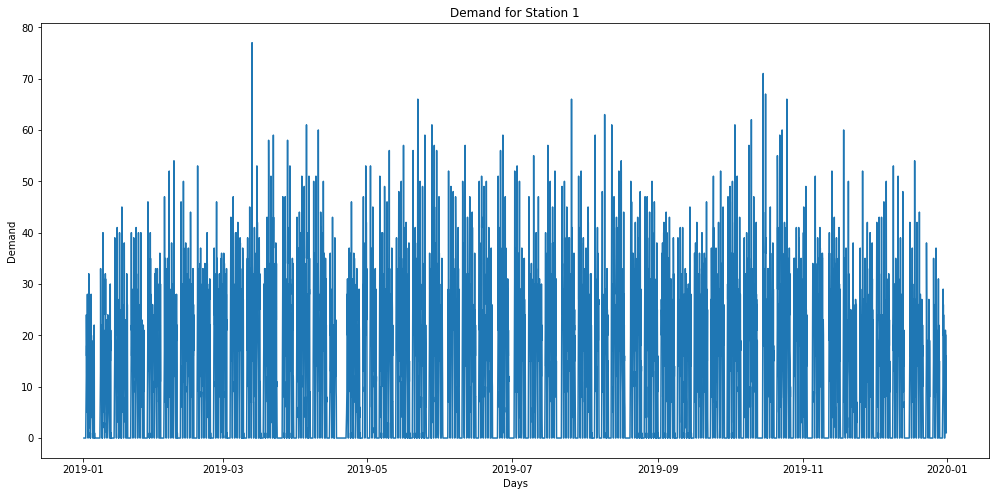

In [64]:
plt.figure(figsize=(17, 8))
plt.plot(df.demand)
plt.title('Demand for Station 1')
plt.ylabel('Demand')
plt.xlabel('Days')
plt.grid(False)
plt.show()

In [65]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

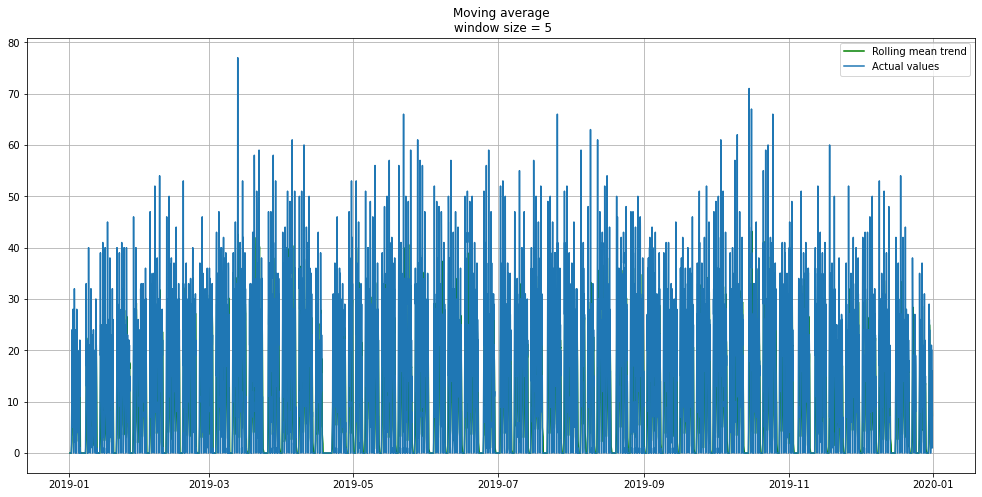

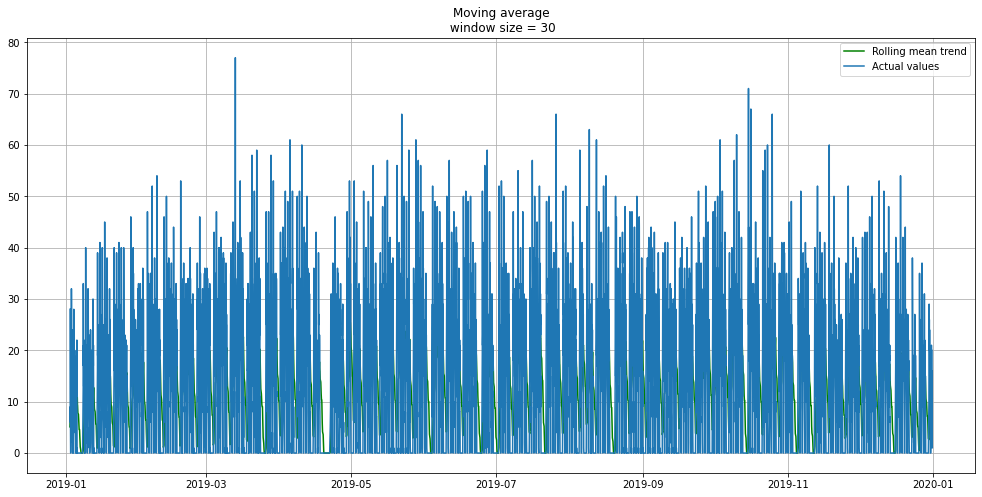

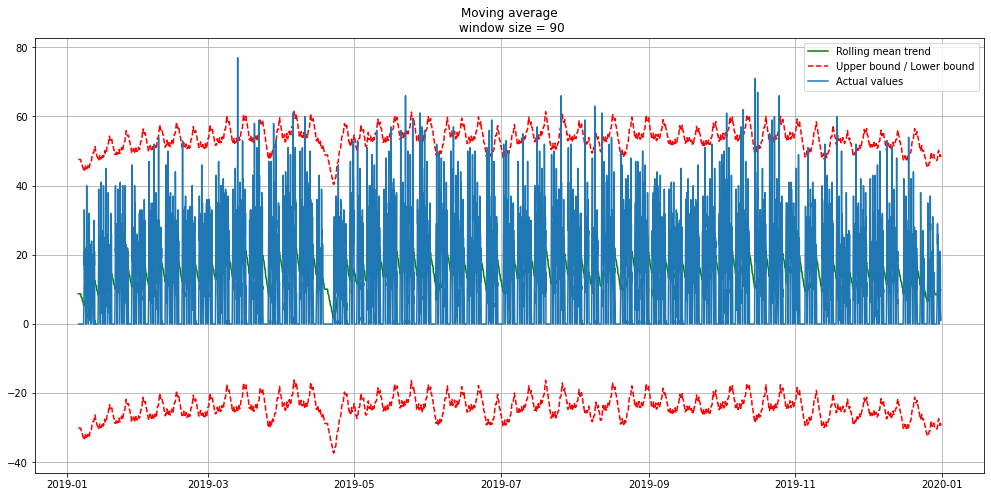

In [66]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 5 days (by week)
plot_moving_average(df.demand, 5)

#Smooth by the previous month (30 days)
plot_moving_average(df.demand, 30)

#Smooth by previous quarter (90 days)
plot_moving_average(df.demand, 90, plot_intervals=True)

We can see that on weekends, the demand for bikes is really small.

In [97]:
df

,demand
year_month_day_hour,
2019-01-01 05:00:00,0.0
2019-01-01 06:00:00,0.0
2019-01-01 07:00:00,0.0
2019-01-01 08:00:00,0.0
2019-01-01 09:00:00,0.0
...,...
2019-12-31 05:00:00,8.0
2019-12-31 06:00:00,21.0
2019-12-31 07:00:00,14.0


In [106]:
month_df = df[df.index.month == 10]
month_df

,demand
year_month_day_hour,
2019-10-01 05:00:00,39.0
2019-10-01 06:00:00,49.0
2019-10-01 07:00:00,16.0
2019-10-01 08:00:00,46.0
2019-10-01 09:00:00,33.0
...,...
2019-10-31 19:00:00,5.0
2019-10-31 20:00:00,4.0
2019-10-31 21:00:00,0.0


<ipython-input-107-d960e1867bdb>:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result_add = seasonal_decompose(df['demand'], model='additive',freq=200)


<Figure size 1080x504 with 0 Axes>

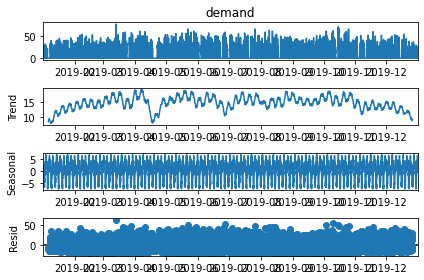

In [107]:
# Additive Decomposition (y = Trend + Seasonal + Residuals)
plt.figure(figsize= (15,7))
result_add = seasonal_decompose(df['demand'], model='additive',freq=200)
result_add.plot();

<ipython-input-108-543939b4c781>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result_add = seasonal_decompose(month_df.demand, model='additive',freq=200)


<Figure size 1080x504 with 0 Axes>

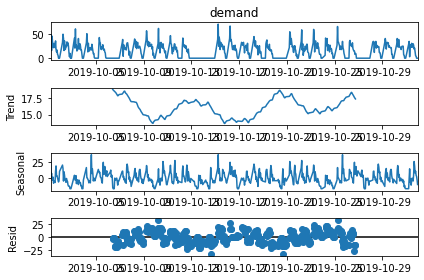

In [108]:
plt.figure(figsize= (15,7))
result_add = seasonal_decompose(month_df.demand, model='additive',freq=200)
result_add.plot();

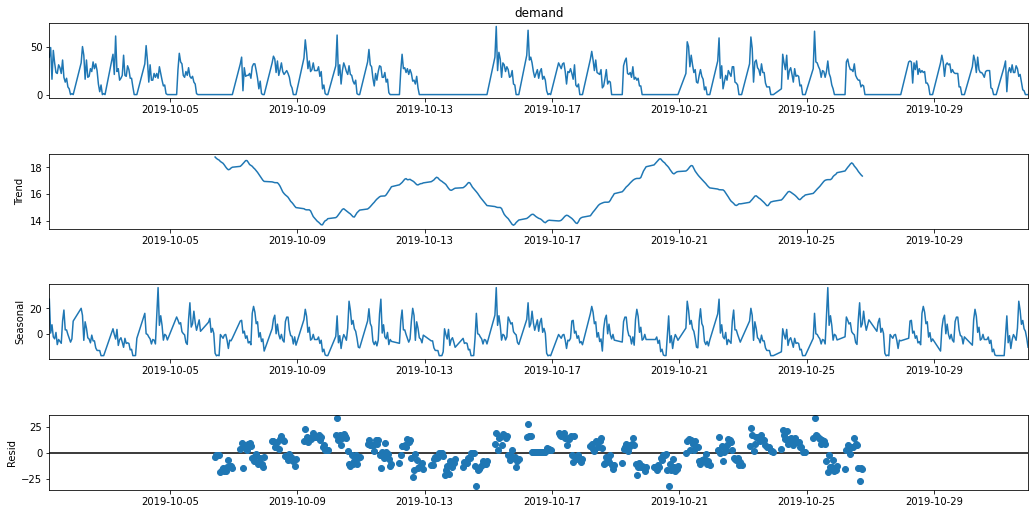

In [109]:
fig = result_add.plot();
fig.set_size_inches(16, 8)

### Dickey-Fuller

In [71]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm

In [72]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title("Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}".format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
    

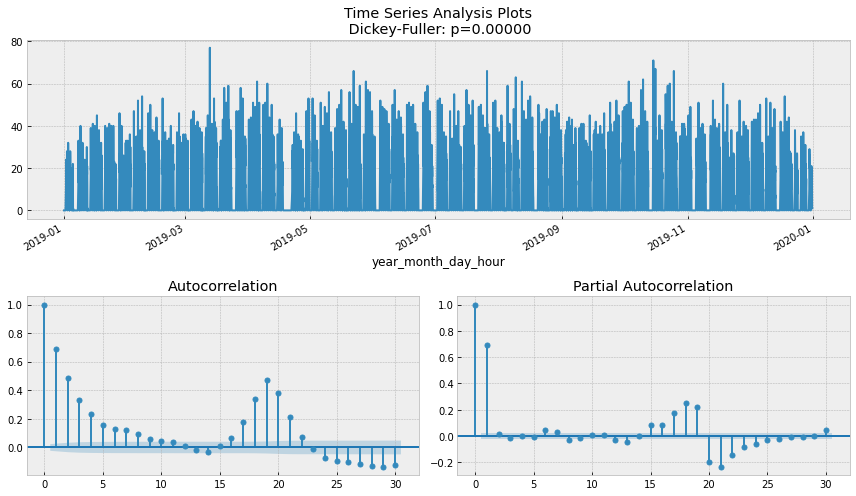

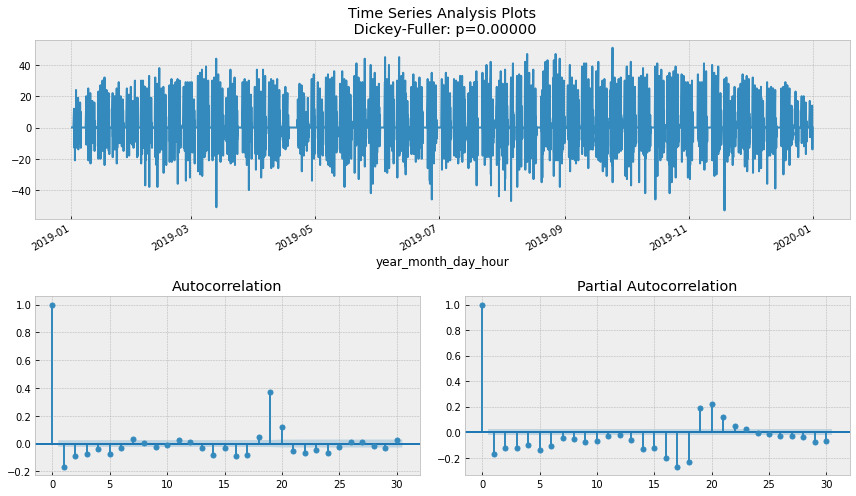

In [89]:
tsplot(df.demand, lags=30)

# Take the first difference to remove to make the process stationary
data_diff = df.demand - df.demand.shift(1)

tsplot(data_diff[1:], lags=30)

### Again

In [92]:
data_diff

year_month_day_hour
2019-01-01 05:00:00     NaN
2019-01-01 06:00:00     0.0
2019-01-01 07:00:00     0.0
2019-01-01 08:00:00     0.0
2019-01-01 09:00:00     0.0
                       ... 
2019-12-31 05:00:00     7.0
2019-12-31 06:00:00    13.0
2019-12-31 07:00:00    -7.0
2019-12-31 08:00:00    -5.0
2019-12-31 09:00:00    11.0
Name: demand, Length: 6927, dtype: float64

<ipython-input-93-1112ca614f60>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result_add = seasonal_decompose(data_diff[1:], model='additive',freq=200)


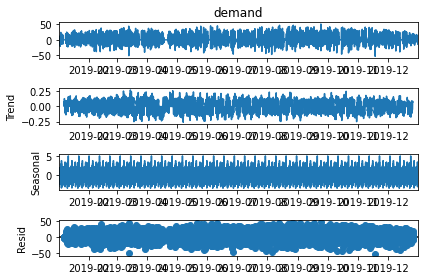

In [93]:
# Additive Decomposition (y = Trend + Seasonal + Residuals)
result_add = seasonal_decompose(data_diff[1:], model='additive',freq=200)
result_add.plot();

### SARIMA 

In [74]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

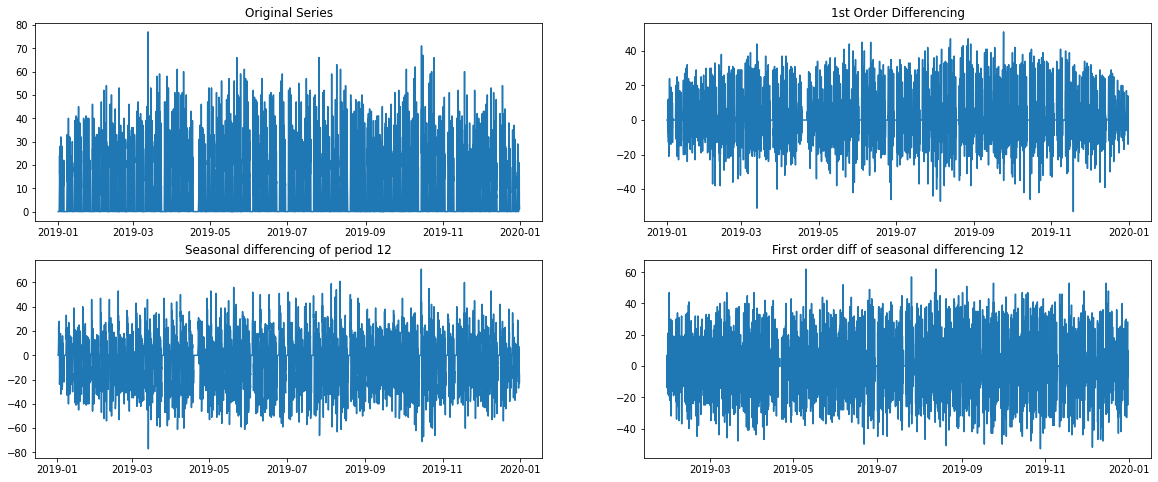

In [86]:
fig, axs = plt.subplots(2, 2, figsize=(20,8))
# Original series
axs[0,0].plot(df.demand); axs[0,0].set_title('Original Series')

# Normal differencing
axs[0,1].plot(df.demand.diff(1)); axs[0,1].set_title('1st Order Differencing')

# Seasonal differencing
axs[1,0].plot(df.demand.diff(17))
axs[1,0].set_title('Seasonal differencing of period 12')

# Sesonal + Normal differencing
axs[1,1].plot(df.demand.diff(520).diff(1))
axs[1,1].set_title('First order diff of seasonal differencing 12');

In [76]:
train = df.demand[0:150]
test = df.demand[150:]

In [77]:
from pmdarima.arima import auto_arima 
import pmdarima as pm

In [78]:
smodel = pm.auto_arima(train, seasonal=True, m=12, 
                       start_p=0, max_p=1, max_d=1, start_q=0, max_q=1,
                       start_P=0, max_P=2, max_D=1, start_Q=0, max_Q=2, 
                       trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1074.884, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=946.328, Time=0.60 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=978.725, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1149.720, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=948.698, Time=0.07 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=948.094, Time=1.44 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=2.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=946.059, Time=0.43 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=947.908, Time=1.24 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=8.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1076.883, Time=0.57 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=944.495, Time=1.43 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=945.779, Time=0.14 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=3.26 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC

In [79]:
df.isnull().sum()

demand    0
dtype: int64

In [80]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Build Model
sarima = SARIMAX(train, order=(1, 0, 1),seasonal_order=(1,0,2,12))
sarima = sarima.fit()

# Forecast
results = sarima.get_forecast(len(test), alpha=0.05)
forecast = results.predicted_mean
confidence_int = results.conf_int()

/home/sisto/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/sisto/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/sisto/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [81]:
confidence_int

,lower demand,upper demand
150,-10.753406,11.325143
151,-16.750252,14.085895
152,-19.476808,16.230578
153,-21.101860,17.650665
154,-21.737156,19.010383
...,...,...
6922,-22.374477,22.374477
6923,-22.374477,22.374477
6924,-22.374477,22.374477
6925,-22.374477,22.374477


In [82]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

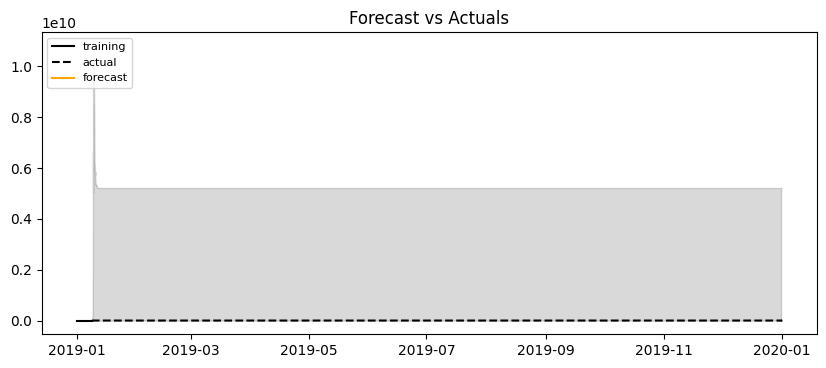

In [83]:
# Reconstruct by taking exponential
forecast_recons = pd.Series(np.exp(forecast), index=test.index)
lower_recons = np.exp(confidence_int['lower demand']).values
upper_recons = np.exp(confidence_int['upper demand']).values

plot_forecast(forecast_recons, train, test, upper = upper_recons, lower=lower_recons)